<a href="https://colab.research.google.com/github/KfirCohen-PyLab/Cloud-Computing-Elephant-team/blob/main/lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install requests beautifulsoup4
!pip install firebase

# Database

In [15]:
from firebase import firebase

firebase_url = 'https://your-firebase-link.firebaseio.com/'
FBconn = firebase.FirebaseApplication(firebase_url, None)

# Base

In [67]:
import requests
from bs4 import BeautifulSoup
import re
from nltk.stem import PorterStemmer

def fetch_page(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        return soup
    else:
        return None

def index_words(soup):
    index = {}
    words = re.findall(r'\b(?!\d+\b)[a-zA-Z_\'-]+\b', soup.get_text())
    for word in words:
        word = word.lower()
        if word in index:
            index[word] += 1
        else:
            index[word] = 1

    return index

def remove_stop_words(index):
    stop_words = {'a', 'an', 'the', 'and', 'or', 'in', 'on', 'at', 'to', 'of', 's', 'with', 'â', 'more'}
    for stop_word in stop_words:
        if stop_word in index:
            del index[stop_word]
    return index

def apply_stemming(index):
    stemmer = PorterStemmer()
    stemmed_index = {}
    for word, count in index.items():
        stemmed_word = stemmer.stem(word)
        if stemmed_word in stemmed_index:
            stemmed_index[stemmed_word] += count
        else:
            stemmed_index[stemmed_word] = count
    return stemmed_index

In [81]:
def search_engine(url):
    soup = fetch_page(url)
    if soup is None:
        return None
    index = index_words(soup)
    index = remove_stop_words(index)
    index = apply_stemming(index)

    sorted_index = dict(sorted(index.items(), key=lambda item: item[1], reverse=True)[:10])

    FBconn.put(f'/sites', 'index', sorted_index)

url = 'https://store.steampowered.com/'
results = search_engine(url)

# Get Index

https://store.steampowered.com/
free: 66
action: 46
apr: 43
rpg: 37
multiplay: 36
world: 32
adventur: 30
simul: 30
open: 27
strategi: 27


Text(0, 0.5, 'Count')

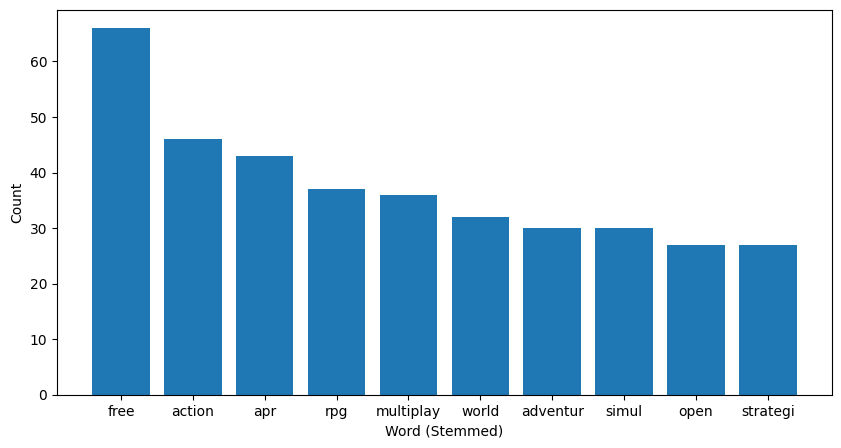

In [82]:
import matplotlib.pyplot as plt

index = FBconn.get(f'/site/index', None)

if index:
    print('https://store.steampowered.com/')

    sorted_index = dict(sorted(index.items(), key=lambda item: item[1], reverse=True))
    for word, count in sorted_index.items():
        print(f"{word}: {count}")
else:
    print('No index found!')

plt.figure(figsize=(10, 5))
plt.bar(sorted_index.keys(), sorted_index.values())
plt.xlabel('Word (Stemmed)')
plt.ylabel('Count')